# Decision tree

## 1. 기본

![iris](http://scikit-learn.org/stable/_images/sphx_glr_plot_iris_0013.png)

- 이전의 classifier들은 linear function으로 데이터를 분류했다. non-linear 데이터에 대해선 SVM의 kernel function을 활용해 차원을 올려서 linear로 분류했다.
- Decision tree는 non-linear 데이터를 특히 잘 분류할 수 있다. Decision tree에선 feature를 attribute라고 주로 칭하는데 이 attribute 별로 조건을 설정해서 데이터를 쪼개나간다. 만약 feature가 공부 시간이라면 10시간 이상인지 미만인지로 조건을 주는 식이다.
- 주로 분류했을 때 area는 위 이미지처럼 사각형 꼴로 각지게 구분된다.
- Decision tree의 장점은
    + kernel을 대체할 수 있다.(대표적으로 non-linear XOR 케이스)
    + 사람이 이해하고, 해석하기에 좋다. 어떤 조건에 따라 분류되었는지, 분류 순서가 어떻게 되었는지 쉽게 파악이 가능하다.
    + Ensemble learning을 하기에 좋다.
    + 학습은 몰라도(중요하지 않다) 예측하는 작업은 굉장히 빠르다. O(height of tree)

## 2. 알고리즘1 : ID3와 classification

"Iterative Dichotomiser 3"의 약자이다.

### 2.1 어떤 attribute를 먼저 사용할 것인가

가장 좋은 attribute를 찾아서 데이터를 나눌 때 먼저 사용해야한다.

#### 2.1.1 Entropy

$$
H(S) = -\sum_{c \in C}p(c)\log{(p(c))} \\
I = H(S) - \sum_{i \in \{L,R\}}{|S^i| \over |S|}H(S^i)
$$

- IG(Information Gain)와 Entropy를 활용해서 가장 좋은 attribute를 찾는다. 구하는 공식은 다음과 같다.
- Entropy : 위 식에서 `H(S)`이고 복잡도를 의미한다. 값이 높을수록 복잡도가 높다. attribute가 2개일 때 Entropy의 변화 그래프는 다음과 같다.

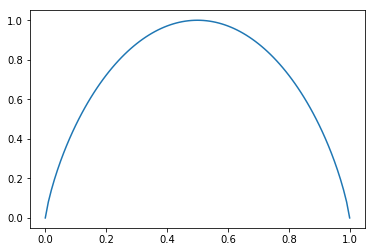

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

def calculate_probabilities(*args):
    total = sum(args)
    return [el / total for el in args]

def calculate_entropy(*args):
    if len(args) == 0:
        raise ValueError('No arguments error')
    probs = calculate_probabilities(*args)
    result = 0
    for el in probs:
        if el == 0: continue
        result -= el * math.log(el, 2)
    return result

x1 = np.arange(0, 1.001, 0.01)
x2 = 1 - x1

y = [calculate_entropy(x1[i], x2[i]) for i in range(len(x1))]
plt.plot(x1, y)
plt.show()

- IG(Information Gain) : 어떤 attribute를 선택했을 때 얻게되는 entropy의 감소 정도를 수치로 나타낸다.
    + 위 공식의 `I`에 해당하는 부분이고
    + `H(S)`는 현재 노드의 복잡도,
    + $|S|, |S_i|$는 전체 example의 개수와, i label의 example 개수를 말한다.
- 각 attribute에 대해서 모두 IG를 구하고 가장 높은 attribute을 선택한다.
- IG를 구하는 코드는 다음과 같다.

In [2]:
def calculate_IG(parent, *children):
    p_en = calculate_entropy(*parent)
    c_en = []
    for child in children:
        c_en.append(sum(child)/sum(parent) * calculate_entropy(*child))
    return p_en - sum(c_en)

calculate_IG([10, 20], [3, 14], [7, 6])

0.1058468751414936

#### 2.1.2 Gini index

$$
G = \sum_{j=1}^{c}P(j)(1-P(j)) = 1 - \sum_{j=1}^{c}P(j)^2 = 1 - \sum_{j=1}^{c}({n_j \over n})^2
$$

- Entropy 말고 gini impurity를 활용해서 attribute를 선택할 수도 있다.
- 위 공식대로 gini를 구하고 entropy가 아닌 gini를 활용한 Information gain을 구해서 활용한다.

### 2.2 기준 정해서 나누기

- 찾은 attribute에 대해서 적절한 기준을 설정하고 분리
- 특정 값을 기준으로 나누기도하고, 명목변수로 나눌 수도 있다.(남자인가 아닌가)

### 2.3 데이터를 언제까지 분리할 것인가

- 두 가지 조건 중 하나를 만족하면 분리를 멈춘다
    + node의 entropy가 0일 때, 즉 해당 노드의 example들이 하나의 y 레이블을 가질 때, pure할 때 멈춘다.
    + 모든 attribute를 다 썼을 때 멈춘다.
- 가능한 끝까지 분리하는 것이기 때문에 overfitting이 무조건 발생하게 되어있다. 이것은 아래에 추가로 설명할 Ensemble learning 방식으로 극복한다.

### 2.4 Overfitting 피하기

![ID3-overfitting](http://slideplayer.com/8111708/25/images/34/Overfitting+As+ID3+adds+new+nodes+to+grow+the+decision+tree%2C+the+accuracy+of+the+tree+measured.+over+the+training+examples+increases+monotonically..jpg)

- Decision tree의 가장 큰 문제점은 overfitting : ID3 알고리즘은 attribute를 다 소모하거나, 모든 노드의 example들이 pure해질 때까지 노드를 추가해나가기 때문에 overfitting이 발생한다.
- node가 많아질수록 training data에 대한 accuracy는 높아지지만 test에 대해선 낮아진다.
- 위와 같은 문제를 해결하기 위해 아래 두 가지 방법을 사용한다.

#### 2.4.1 Setting minimum IG

- IG(Information Gain)이 크지 않은 노드는 더 이상 분리하지 않는다.
- 예를 들어 10,000개 데이터 중에서 9,995개가 A고, 5개만 B라면 더 이상 분리하지 않는다.(즉 minimum IG를 설정하는 것)

#### 2.4.2 Pruning

- 일단 ID3 알고리즘으로 가능한 최대 크기로 tree를 만든다.
- 데이터셋을 train, validation, test 셋으로 나눈다.
    + 100개 데이터 -> 50 / 30, 20
    + validation이 필요한 이유는 y label이 없는 test 데이터셋에 decision tree를 적용하기 전에 tree가 제대로 동작하는지 확인하기 위해서다.
    + 아래 추가로 설명하듯이 여러가지의 sub tree 중 하나를 골라야하기 때문
- 전체 tree에서 subtree를 하나씩 없애본다. parent node만 남기고 child node를 없애보는 것
- subtree를 없애본 모든 시도에 대해서 각각을 validation 데이터셋에 적용해보고 accuracy를 측정한다.
- 가장 높은 accuracy를 보인 subtree를 선택

## 3. 알고리즘2 : Regression

### 3.1 Loss 설정

$$
\text{RSS} = \sum_{j=1}^J\sum_{i \in R_j}(Y^{(i)} - \hat{Y_{R_j}})^2
$$

- P개의 feature($X_1,X_2,...,X_P$)로 구성된 공간을 J개의 겹치지 않는 구역($R_1,R_2,...,R_J$)으로 나눈다.
- $R_J$ 구역의 예측값은 그 구역의 mean 값이다
- 구역별로 속한 데이터들의 Y값과 구역의 예측값을의 차를 제곱해서 모두 더하는 RSS를 최소화하는 구역들을 찾는다.

### 3.2 구역 찾기

- 위 Loss를 최소화하는 구역은 한 번에 찾을 수 없기 때문에 불완전하더라도 다음 방식을 사용한다.
- top-down, greedy approach -> recursive binary splitting
    + top-down: P개의 feature로 이뤄진 공간을 위에서부터 아래로 쪼개나가는 방식(트리의 모양을 생각)
    + Greedy: 현재 상태에서 가장 최선의 선택을 하는 것. 첫 번째 쪼개는 feature가 최선이 아니더라도 그 순간에서 최선의 선택을 해나간다. 이후의 조합에 대해선 신경쓰지 않겠다는 의미
- 순서
    + feature 하나를 정하고, RSS를 가장 크게 줄이는 cutpoint를 정한다.
    + cutpoint로 구역을 두 개 나누고, 나눠진 구역 모두에서 계속 같은 작업을 반복한다.
    + 반복 종료 조건: 한 구역에 속한 데이터가 특정 개수 이하일 때, RSS가 더 이상 작아지지 않을 때까지

### 3.3 Cost complexity pruning

- 3.2의 방법까지만 하면 overfitting 문제 발생할 수 있다. 데이터에 대한 이해 없이 반복 종료 조건을 설정하면 굳이 더 이상 쪼갤 필요 없는데도 계속 데이터를 쪼개나갈 수 있기 때문이다.
- 그래서 Pruning, 가지치기 방법을 사용한다.
- 순서
    + 설정한 반복 종료 조건에 맞춰서 일단 최대한 크게 트리를 만든다. 이 트리를 $T_0$라 부른다.
    + 가지를 친다. 즉 가장 데이터를 잘 분류하는, RSS가 가장 작은 subtree를 구한다.

$$
\underset{T}{\arg\min}_T \sum_{m=1}^{|T|}\sum_{i \in R_m}(Y^{(i)} - \hat{Y_{R_j}})^2 + \alpha|T|
$$

> `|T|` : 구역의 개수, 즉 terminal node(leaf)의 개수를 의미

- 위 공식처럼 가지의 개수를 페널티로 줘서 가장 적합한 subtree를 구한다.
- 먼저 알파 값은 적당한 양수 값을 하나 정해서 고정하고 일단 적합한 |T|부터 찾는다.
- 알파값은 나중에 k-fold cross-validation을 통해 prediction-error를 최소화시키는 값으로 정한다.
    + 데이터를 train, validation set으로 나눈다.
    + 알파를 변경해가며 모든 데이터셋에 대한 에러값을 계산하고 각각의 k-fold 셋마다 sum한다.
    + 알파값 중 k-fold의 모든 데이터셋에 대한 에러의 합이 가장 적은 것을 선택

## 4. Random forest

Decision tree를 단일로 사용하면 accuracy가 낮다. 이를 극복하기 위해 다음 Bagging과 Random Subspace 방법을 모두 사용하고 그것을 Random forest라고 한다.

### 4.1 Bagging

- Bootstrap Aggregating의 합성어
    + Bootstrapping: 원본 데이터셋에서 일정 부분을 여러번 무작위 복원추출하는 것
    + Aggregating: 여러 트리를 종합해서 majority voting으로 결정하는 것
- 방식
    + training data가 n개가 있을 때, 랜덤하게 k개를 뽑는 작업을 b번 반복한다.
    + 즉 k 크기의 데이터 셋 (X_b, Y_b) 쌍이 b개 생긴다.
    + 이 데이터셋에 ID3 알고리즘을 적용해서 b개의 tree를 생성한다.
    + 새로운 데이터가 들어오면 b개의 tree를 동시에 사용해서 다수결(majority vote) 방식으로 분류한다.
- Bias-Variance Trade Off
    + Bias가 높으면 예측치가 실제값과 비교해 부정확함. 낮을수록 좋다.
    + Variance가 높으면 특정 데이터셋에 너무 overfitting된 것
    + Bagging 방식은 bias를 낮게 유지하면서 variance를 낮출 수 있다. 즉 accuracy를 높일 수 있다.

### 4.2 Random subspace

- 원래는 노드를 나눌 때 IG가 최대가 되는 attribute를 선택해서 나눈다.
- 하지만 굉장히 강력한 attribute가 있을 경우 Bagging 방식을 이용해봤자 다들 비슷하게 되거나 그 attribute 방향으로 모델이 치우쳐질 수 있다.
- 그래서 attribute를 IG와 관계없이 랜덤으로 선택한다. Feature Bagging 방식이라고도 불린다.
- 랜덤으로 선택하는 방법은 전체 P개의 feature를 모두 사용하는 것이 아니고 P보다 작은 m개의 feature만 사용하는 것. 이 때 m은 $\sqrt P$ 또는 $floor(\log{P} + 1)$ 에 근사하는 값으로 한다.

### 4.3 Boosting

- Bagging과 유사하지만 조금 다른 개념
- 분류
    + Ensemble learning: 동일한 전체 데이터셋에 대해 다양한 분류기를 사용한 후 voting
    + Bagging: 전체 데이터셋에서 랜덤 샘플링한 다음 각각 샘플에 대해 분류기를 사용한 후 voting
    + Boosting: 전체 데이터셋에서 랜덤 샘플링하는 것은 Bagging과 동일
        + 다만 Bagging은 각각의 랜덤 샘플에 대해 서로 독립적으로 학습을 하지만
        + Boosting은 순차적으로 첫 샘플의 가중치를 다음 샘플에 적용한 후 학습한다.
